In [1]:
%%time
import cudf
import cuspatial as csp
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon
import os

CPU times: user 966 ms, sys: 972 ms, total: 1.94 s
Wall time: 1.3 s


In [2]:
%%time
yrs = [str(x) for x in (2019,2020,2021)]
file_names = []
for yr in yrs:
    file_names += [f"../../US_MARINE/{yr}/parquets/" + x for x in os.listdir(f"../../US_MARINE/{yr}/parquets/")]
cargo_file_names = sorted([x for x in file_names if "cargo" in x])
tanker_file_names = sorted([x for x in file_names if "tanker" in x])

CPU times: user 0 ns, sys: 1.96 ms, total: 1.96 ms
Wall time: 2.26 ms


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Region    1 non-null      object  
 1   geometry  1 non-null      geometry
dtypes: geometry(1), object(1)
memory usage: 144.0+ bytes
None


<AxesSubplot:>

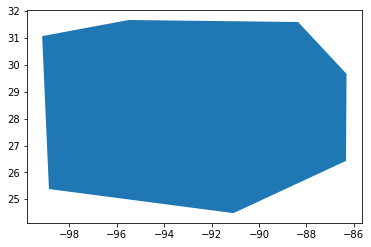

In [3]:
gom = Polygon([[-99.140625, 31.071755902820133],
            [-98.85498046875, 25.383735254706867],
            [-91.07666015625, 24.487148563173424],
            [-86.33056640625, 26.43122806450644],
            [-86.30859375, 29.668962525992505],
            [-88.35205078124999,31.59725256170666],
            [-95.49316406249999, 31.672083485607402],
            [-99.140625,31.071755902820133]])
df = pd.DataFrame([['GOM',gom]], columns=['Region','geometry'])
df = gpd.GeoDataFrame(df, geometry='geometry', crs=4326)
print(df.info())
df.plot()

In [4]:
offsets = [0]
poly_points_x = []
poly_points_y = []
idx = []
for region in df.Region.unique():
    poly_points_x += [x[0] for x in df[df.Region == region].geometry.__geo_interface__['features'][0]['geometry']['coordinates'][0][:-1]]
    poly_points_y += [x[1] for x in df[df.Region == region].geometry.__geo_interface__['features'][0]['geometry']['coordinates'][0][:-1]]
    offsets += [len(poly_points_x)]
    idx += [region]
offsets = offsets[:-1]
offsets, idx
# poly_points_y = [x[1] for x in df[df.Region == "GOM"].geometry.__geo_interface__['features'][0]['geometry']['coordinates'][0][:-1]]

([0], ['GOM'])

In [5]:
%%time
vessel_names_list = []
list_of_gom_cdfs = []
gomcdf = cudf.DataFrame()
for i, f in enumerate(tanker_file_names[:]):
    tmp = cudf.read_parquet(f)
    t = csp.point_in_polygon(tmp.LON, tmp.LAT, cudf.Series([x for x in range(len(idx))], index=idx), offsets ,poly_points_x,poly_points_y)
    vessels = tmp.VesselName.unique().to_arrow().tolist()
    vessel_names_list += vessels
    tmp_gom = tmp.loc[t[t.GOM == True].index][['BaseDateTime','MMSI','LAT','LON','VesselName','IMO','SOG']]
    gomcdf = cudf.concat([gomcdf, tmp.loc[t[t.GOM == True].index][['BaseDateTime','MMSI','LAT','LON','VesselName','IMO','SOG']]], ignore_index=True)
    del tmp
    if i % 20 == 0:
        print(i, f)
# cargo_vessel_names = set(vessel_names_list)
# gomcdf = cudf.concat(list_of_gom_cdfs, ignore_index=True)
gomcdf.to_parquet("ALL_GOM_tanker_2019-2021.parquet")
gomcdf

0 ../../US_MARINE/2019/parquets/AIS_2019_01_01_tanker_5min.parquet
20 ../../US_MARINE/2019/parquets/AIS_2019_01_21_tanker_5min.parquet
40 ../../US_MARINE/2019/parquets/AIS_2019_02_10_tanker_5min.parquet
60 ../../US_MARINE/2019/parquets/AIS_2019_03_02_tanker_5min.parquet
80 ../../US_MARINE/2019/parquets/AIS_2019_03_22_tanker_5min.parquet
100 ../../US_MARINE/2019/parquets/AIS_2019_04_11_tanker_5min.parquet
120 ../../US_MARINE/2019/parquets/AIS_2019_05_01_tanker_5min.parquet
140 ../../US_MARINE/2019/parquets/AIS_2019_05_21_tanker_5min.parquet
160 ../../US_MARINE/2019/parquets/AIS_2019_06_10_tanker_5min.parquet
180 ../../US_MARINE/2019/parquets/AIS_2019_06_30_tanker_5min.parquet
200 ../../US_MARINE/2019/parquets/AIS_2019_07_20_tanker_5min.parquet
220 ../../US_MARINE/2019/parquets/AIS_2019_08_09_tanker_5min.parquet
240 ../../US_MARINE/2019/parquets/AIS_2019_08_29_tanker_5min.parquet
260 ../../US_MARINE/2019/parquets/AIS_2019_09_18_tanker_5min.parquet
280 ../../US_MARINE/2019/parquets/AIS_20

,BaseDateTime,MMSI,LAT,LON,VesselName,IMO,SOG
0,2019-01-01 00:00:00,403638000.0,28.52015,-94.34360,GHINAH,IMO9484728,0.1
1,2019-01-01 00:05:00,403638000.0,28.52016,-94.34354,GHINAH,IMO9484728,0.1
2,2019-01-01 00:10:00,403638000.0,28.52004,-94.34356,GHINAH,IMO9484728,0.0
3,2019-01-01 00:15:00,403638000.0,28.52007,-94.34355,GHINAH,IMO9484728,0.1
4,2019-01-01 00:20:00,403638000.0,28.51993,-94.34365,GHINAH,IMO9484728,0.1
...,...,...,...,...,...,...,...
38903728,2021-12-31 23:35:00,538005036.0,27.31645,-88.56486,PALANCA SINGAPORE,IMO9492361,11.9
38903729,2021-12-31 23:40:00,538005036.0,27.33180,-88.56925,PALANCA SINGAPORE,IMO9492361,11.9
38903730,2021-12-31 23:45:00,538005036.0,27.34397,-88.57778,PALANCA SINGAPORE,IMO9492361,11.9
38903731,2021-12-31 23:50:00,538005036.0,27.35543,-88.58380,PALANCA SINGAPORE,IMO9492361,12.0
